In [112]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [113]:
in_dir = Path("data/processed/03")
folds = {}
for i in range(1, 3):
    print(f"Reading fold {i}:")
    folds[f"fold_{i}"] = {
        "X_train": pd.read_csv(f'{in_dir}/fold_{i}_X_train.csv'),
        "X_test": pd.read_csv(f'{in_dir}/fold_{i}_X_test.csv'),
        "y_train": pd.read_csv(f'{in_dir}/fold_{i}_y_train.csv').squeeze(),
        "y_test": pd.read_csv(f'{in_dir}/fold_{i}_y_test.csv').squeeze()
    }

X_train = folds["fold_1"]["X_train"];
y_train = folds["fold_1"]["y_train"];
y_test = folds["fold_1"]["y_test"];

print("Ready for Feature Classification:")
print(f"  Training features: {X_train.shape}")
print(f"  Features to classify: {len(X_train.columns)}")
print(f"  Data integrity verified: ✅")

Reading fold 1:
Reading fold 2:
Ready for Feature Classification:
  Training features: (8495, 10)
  Features to classify: 10
  Data integrity verified: ✅


In [114]:
X_train.describe()

,num__temp_C,num__dewpoint_C,num__slp_hPa,num__wind_dir_deg,cat__sky_cover_0,cat__sky_cover_1,dt__dt__hour,dt__dt__dow,dt__dt__month,dt__dt__is_weekend
count,8.495000e+03,8.495000e+03,8.495000e+03,8.495000e+03,8495.000000,8495.000000,8.495000e+03,8.495000e+03,8.495000e+03,8.495000e+03
mean,8.029677e-17,4.182123e-17,2.970980e-15,-7.360537e-17,0.780224,0.007416,-6.963235e-17,-8.029677e-17,-1.070624e-16,-6.942325e-17
std,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00,0.414119,0.085802,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00
min,-3.002637e+00,-3.394120e+00,-2.868419e+00,-1.846816e+00,0.000000,0.000000,-1.613084e+00,-1.502400e+00,-1.942616e+00,-6.379050e-01
25%,-8.337260e-01,-7.368357e-01,-6.852662e-01,-9.813172e-01,1.000000,0.000000,-9.011579e-01,-1.002874e+00,-7.208179e-01,-6.379050e-01
50%,-9.539888e-03,-2.088343e-02,-1.261662e-01,3.650139e-01,1.000000,0.000000,-4.684714e-02,-3.822154e-03,1.955309e-01,-6.379050e-01
75%,7.604234e-01,8.327520e-01,7.257959e-01,8.458464e-01,1.000000,0.000000,9.498488e-01,9.952301e-01,8.064301e-01,1.567631e+00
max,2.571464e+00,2.347266e+00,3.028756e+00,1.519012e+00,1.000000,1.000000,1.661774e+00,1.494756e+00,1.417329e+00,1.567631e+00


In [115]:
pipeline = Pipeline(steps=[('regressor', LinearRegression())])

In [116]:
print(folds["fold_1"]["y_train"])

0       51.445213
1        4.155905
2        2.686866
3        2.109964
4        2.770088
          ...    
8490    15.906068
8491    14.350314
8492    16.194435
8493    16.287197
8494    18.220762
Name: target, Length: 8495, dtype: float64


In [117]:
for fold_name, d in folds.items():
    print(f"Processing {fold_name}...")

    X_train = d["X_train"].select_dtypes(include=np.number).copy()
    X_test  = d["X_test"].select_dtypes(include=np.number).copy()
    y_train = pd.to_numeric(d["y_train"], errors="coerce").squeeze()
    y_test  = pd.to_numeric(d["y_test"],  errors="coerce").squeeze()

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print(f"Test MSE for {fold_name}: {mse:.2f}")

Processing fold_1...
Test MSE for fold_1: 504.58
Processing fold_2...
Test MSE for fold_2: 437.18


In [118]:
for fold_name, d in folds.items():
    print(f"Processing {fold_name}...")

    X_train = d["X_train"].select_dtypes(include=np.number).copy()
    X_test  = d["X_test"].select_dtypes(include=np.number).copy()
    y_train = pd.to_numeric(d["y_train"], errors="coerce").squeeze()
    y_test  = pd.to_numeric(d["y_test"],  errors="coerce").squeeze()

    # Statistical selection (correlation-based)*
    selector = SelectKBest(score_func=f_regression, k=10)
    X_selected = selector.fit_transform(X_train, y_train)
    selected_features = X_train.columns[selector.get_support()]

    # Model-based selection*
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Get feature importances*
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"Feature importance for {fold_name}:/n{feature_importance}")

    # Select top features*
    top_features = feature_importance.head(10)['feature'].tolist()
    X_top = X_train[top_features]

    print(f"Top features for {fold_name}:/n{top_features}")

    # Recursive feature elimination*
    rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
    X_rfe = rfe.fit_transform(X_train, y_train)
    selected_features_rfe = X_train.columns[rfe.support_]

    print(f"Selected features for {fold_name}:/n{selected_features_rfe}")

    # PCA for dimensionality reduction*
    pca = PCA(n_components=0.95)  # Keep 95% of variance
    X_pca = pca.fit_transform(X_train)
    print(f"PCA reduced {X_train.shape[1]} features to {X_pca.shape[1]} components")

    # Compare methods*
    print("\nFeature Selection Comparison:")
    print(f"Statistical selection: {len(selected_features)} features")
    print(f"Importance-based: {len(top_features)} features")
    print(f"RFE: {len(selected_features_rfe)} features")
    print(f"PCA: {X_pca.shape[1]} components")

Processing fold_1...
Feature importance for fold_1:/n              feature  importance
3   num__wind_dir_deg    0.203653
2        num__slp_hPa    0.198319
6        dt__dt__hour    0.146819
1     num__dewpoint_C    0.120307
8       dt__dt__month    0.115410
0         num__temp_C    0.096485
4    cat__sky_cover_0    0.044310
7         dt__dt__dow    0.042143
5    cat__sky_cover_1    0.024001
9  dt__dt__is_weekend    0.008553
Top features for fold_1:/n['num__wind_dir_deg', 'num__slp_hPa', 'dt__dt__hour', 'num__dewpoint_C', 'dt__dt__month', 'num__temp_C', 'cat__sky_cover_0', 'dt__dt__dow', 'cat__sky_cover_1', 'dt__dt__is_weekend']
Selected features for fold_1:/nIndex(['num__temp_C', 'num__dewpoint_C', 'num__slp_hPa', 'num__wind_dir_deg',
       'cat__sky_cover_0', 'cat__sky_cover_1', 'dt__dt__hour', 'dt__dt__dow',
       'dt__dt__month', 'dt__dt__is_weekend'],
      dtype='object')
PCA reduced 10 features to 7 components

Feature Selection Comparison:
Statistical selection: 10 features
Imp

In [119]:
model = LinearRegression()
model.fit(X_train, y_train)
print(f"Score: {model.score(X_test, y_test):.3f}")

Score: -0.367


In [120]:
# View coefficients*
coefs = pd.DataFrame({'feature': X_train.columns, 'impact': model.coef_})
print(coefs.sort_values('impact', key=abs, ascending=False))

              feature     impact
5    cat__sky_cover_1  16.392457
6        dt__dt__hour   9.068334
4    cat__sky_cover_0  -7.523477
0         num__temp_C  -7.044366
9  dt__dt__is_weekend  -4.814840
8       dt__dt__month  -2.883428
2        num__slp_hPa   2.023864
3   num__wind_dir_deg  -1.959916
1     num__dewpoint_C   1.586127
7         dt__dt__dow   1.096788


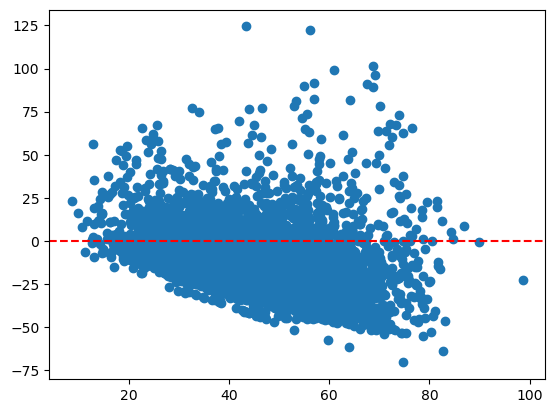

In [121]:
residuals = y_test - model.predict(X_test)
plt.scatter(model.predict(X_test), residuals)
plt.axhline(0, color='red', linestyle='--')
plt.show()

In [122]:
ridge = Ridge(alpha=1.0)  # alpha controls penalty strength
lasso = Lasso(alpha=0.1)
ridge = RidgeCV(alphas=[0.1, 1, 10])  # Auto-selects best alpha
ridge.fit(X_train, y_train)
print(f"Best alpha: {ridge.alpha_}")

Best alpha: 10.0


In [123]:
lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)
selected_features = X_train.columns[lasso.coef_ != 0]
print(f"Selected: {list(selected_features)}")

Selected: ['num__temp_C', 'num__slp_hPa', 'num__wind_dir_deg', 'cat__sky_cover_0', 'dt__dt__hour', 'dt__dt__month', 'dt__dt__is_weekend']


In [124]:
grid = GridSearchCV(Ridge(), {'alpha': [0.1, 1, 10]}, cv=5)
grid.fit(X_train, y_train)
print(f"Best alpha: {grid.best_params_}")

Best alpha: {'alpha': 10}


In [125]:
models = {'Linear': LinearRegression(), 'Ridge': RidgeCV(), 'Lasso': LassoCV()}
for fold_name, d in folds.items():
    print(f"Processing {fold_name}...")

    X_train = d["X_train"].select_dtypes(include=np.number).copy()
    X_test  = d["X_test"].select_dtypes(include=np.number).copy()
    y_train = pd.to_numeric(d["y_train"], errors="coerce").squeeze()
    y_test  = pd.to_numeric(d["y_test"],  errors="coerce").squeeze()
    for name, model in models.items():
        score = cross_val_score(model, X_train, y_train, cv=5).mean()
        print(f"{name}: {score:.3f}")

Processing fold_1...
Linear: 0.089
Ridge: 0.093
Lasso: 0.107
Processing fold_2...
Linear: 0.116
Ridge: 0.117
Lasso: 0.129


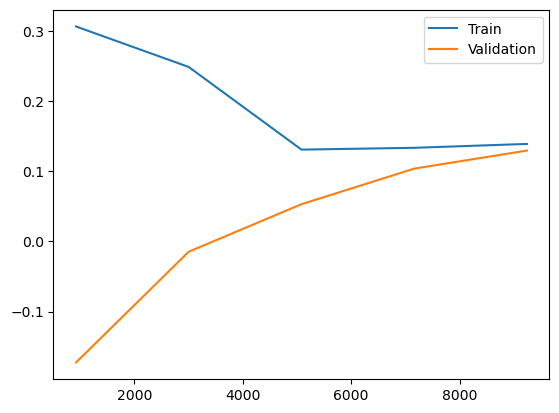

In [126]:
train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=5)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation')
plt.legend()
plt.show()